In [1]:
import numpy as np
from json_tricks import dumps, loads
from tqdm import tqdm
import pandas as pd

import torch
import torch.nn.functional as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
from tensorflow.examples.tutorials.mnist import input_data
from sklearn.model_selection import train_test_split

In [2]:
mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)


Extracting ../../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../../MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
i = 0
lines = []
with open("data/data4/fl4-comb.txt") as f:
    for line in f:
        lines.append(line)

In [4]:
Qs = []
for i in tqdm(range(len(lines))):
    map_str_comb, dic = lines[i].split("\t")
    obj = loads(dic)
    Qs.append(obj['Q'])
#     print(map_str_comb)
#     print(obj['Q'])
#     print(obj['start'])
#     print(obj['end'])
#     print(obj['score'])

100%|██████████| 3828/3828 [00:01<00:00, 3201.16it/s]


In [5]:
data = pd.DataFrame(np.array([list(q.flatten()) for q in Qs]))
# data

In [6]:
np.array(data.describe().loc['mean']).reshape((16,4))

array([[0.12195581, 0.08256955, 0.08251324, 0.12372228],
       [0.0821906 , 0.05761942, 0.05719702, 0.09444015],
       [0.07815579, 0.0540326 , 0.06380972, 0.07943222],
       [0.08916016, 0.08788628, 0.11889415, 0.08951577],
       [0.09738987, 0.05795529, 0.05877805, 0.08288135],
       [0.05276304, 0.05120913, 0.05172947, 0.05426049],
       [0.07073826, 0.08033005, 0.07113202, 0.06475014],
       [0.11527473, 0.18617917, 0.17126957, 0.11207997],
       [0.08072407, 0.06367607, 0.05345485, 0.07876516],
       [0.06687505, 0.07218775, 0.08300659, 0.07017861],
       [0.12329497, 0.15297471, 0.15264606, 0.12188077],
       [0.23387151, 0.39187228, 0.36675139, 0.22995599],
       [0.09059788, 0.11839352, 0.0876327 , 0.088986  ],
       [0.10975108, 0.1710683 , 0.18492716, 0.11169723],
       [0.2356622 , 0.35998902, 0.39185281, 0.22972349],
       [0.        , 0.        , 0.        , 0.        ]])

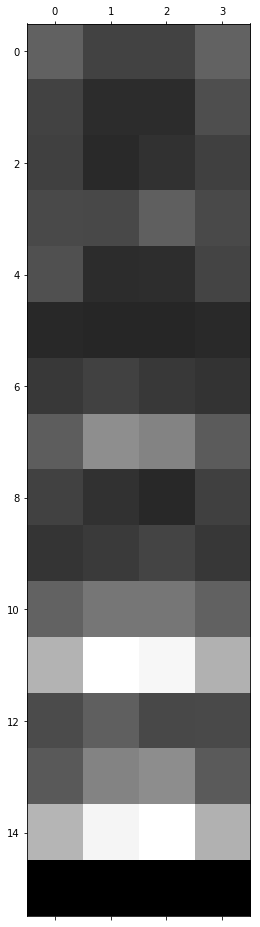

In [7]:
plt.matshow(np.array(data.describe().loc['mean']).reshape((16,4)), cmap='Greys_r')

In [8]:
q_data = np.array([q.flatten() for q in Qs])

In [9]:
X_train, X_test = train_test_split(q_data, test_size=0.10, random_state=42)

In [10]:
mb_size = 32
Z_dim = 100
X_dim = X_train.shape[1]
# X_dim = mnist.train.images.shape[1]
h_dim = 40
c = 0
lr = 1e-3

In [11]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return Variable(torch.randn(*size) * xavier_stddev, requires_grad=True)

In [12]:
""" ==================== GENERATOR ======================== """

Wzh = xavier_init(size=[Z_dim, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)

Whx = xavier_init(size=[h_dim, X_dim])
bhx = Variable(torch.zeros(X_dim), requires_grad=True)


def G(z):
    h = nn.relu(z @ Wzh + bzh.repeat(z.size(0), 1))
    X = nn.sigmoid(h @ Whx + bhx.repeat(h.size(0), 1))
    return X

In [13]:
""" ==================== DISCRIMINATOR ======================== """

Wxh = xavier_init(size=[X_dim, h_dim])
bxh = Variable(torch.zeros(h_dim), requires_grad=True)

Why = xavier_init(size=[h_dim, 1])
bhy = Variable(torch.zeros(1), requires_grad=True)


def D(X):
    h = nn.relu(X @ Wxh + bxh.repeat(X.size(0), 1))
    y = nn.sigmoid(h @ Why + bhy.repeat(h.size(0), 1))
    return y


G_params = [Wzh, bzh, Whx, bhx]
D_params = [Wxh, bxh, Why, bhy]
params = G_params + D_params

In [14]:
""" ===================== TRAINING ======================== """

def reset_grad():
    for p in params:
        if p.grad is not None:
            data = p.grad.data
            p.grad = Variable(data.new().resize_as_(data).zero_())

G_solver = optim.Adam(G_params, lr=1e-3)
D_solver = optim.Adam(D_params, lr=1e-3)

ones_label = Variable(torch.ones(mb_size))
zeros_label = Variable(torch.zeros(mb_size))

In [15]:
def next_batch(num, data):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0, len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    return data[idx]

In [ ]:

for it in range(100000):
    # Sample data
    z = Variable(torch.randn(mb_size, Z_dim))
#     X, _ = mnist.train.next_batch(mb_size)
    X = next_batch(mb_size, X_train)
    X = Variable(torch.from_numpy(X).float())

    # Dicriminator forward-loss-backward-update
    G_sample = G(z)
    D_real = D(X)
    D_fake = D(G_sample)

    D_loss_real = nn.binary_cross_entropy(D_real, ones_label)
    D_loss_fake = nn.binary_cross_entropy(D_fake, zeros_label)
    D_loss = D_loss_real + D_loss_fake

    D_loss.backward()
    D_solver.step()

    # Housekeeping - reset gradient
    reset_grad()

    # Generator forward-loss-backward-update
    z = Variable(torch.randn(mb_size, Z_dim))
    G_sample = G(z)
    D_fake = D(G_sample)

    G_loss = nn.binary_cross_entropy(D_fake, ones_label)

    G_loss.backward()
    G_solver.step()

    # Housekeeping - reset gradient
    reset_grad()

    # Print and plot every now and then
    if it % 1000 == 0:
        print('Iter-{}; D_loss: {}; G_loss: {}'.format(it, D_loss.data.numpy(), G_loss.data.numpy()))

        samples = G(z).data.numpy()[:16]

        fig = plt.figure(figsize=(4, 4))
        gs = gridspec.GridSpec(4, 4)
        gs.update(wspace=0.05, hspace=0.05)

        for i, sample in enumerate(samples):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(sample.reshape(16, 4), cmap='Greys_r')

        if not os.path.exists('out/'):
            os.makedirs('out/')

        plt.savefig('out/{}.png'.format(str(c).zfill(3)), bbox_inches='tight')
        c += 1
        plt.close(fig)

/Users/gvsi/anaconda3/envs/gan/lib/python3.6/site-packages/torch/nn/functional.py:1168: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Iter-0; D_loss: [1.5710366]; G_loss: [0.52704453]
Iter-1000; D_loss: [1.2924922]; G_loss: [0.77230173]
Iter-2000; D_loss: [1.2746984]; G_loss: [0.8115677]
Iter-3000; D_loss: [1.2224678]; G_loss: [0.77875286]
Iter-4000; D_loss: [1.4340537]; G_loss: [0.78227544]
Iter-5000; D_loss: [1.3934699]; G_loss: [0.93907857]
Iter-6000; D_loss: [1.2604795]; G_loss: [0.908802]
Iter-7000; D_loss: [1.1772506]; G_loss: [1.1064316]
Iter-8000; D_loss: [1.1307936]; G_loss: [0.89670444]
Iter-9000; D_loss: [1.2526524]; G_loss: [0.9836535]
Iter-10000; D_loss: [1.2759435]; G_loss: [0.80982125]
Iter-11000; D_loss: [1.1886551]; G_loss: [0.9661324]
Iter-12000; D_loss: [1.072839]; G_loss: [0.80148476]
Iter-13000; D_loss: [1.1911745]; G_loss: [0.8232041]
Iter-14000; D_loss: [1.383947]; G_loss: [0.7831403]
Iter-15000; D_loss: [1.3972119]; G_loss: [0.7602152]
Iter-16000; D_loss: [1.2598553]; G_loss: [0.83323]
Iter-17000; D_loss: [1.4081066]; G_loss: [0.7366711]
Iter-18000; D_loss: [1.3211932]; G_loss: [0.77463526]
It

In [18]:
inputs = Variable(torch.from_numpy(X_test[:32]).float(), requires_grad=True)

In [19]:
inputs[0].data.numpy().reshape((16,4))

array([[0.15333582, 0.0329516 , 0.12457457, 0.1492146 ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.30415007, 0.23366085, 0.14658506, 0.06507196],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.29920027, 0.01608911, 0.06598258, 0.19960965],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.45623335, 0.40752405, 0.5204927 , 0.3729392 ],
       [0.00261711, 0.6146905 , 0.0233491 , 0.13710801],
       [0.13392164, 0.7542627 , 0.15535785, 0.03055874],
       [0.        , 0.        , 0.        , 0.        ]], dtype=float32)

In [20]:
myD = D(inputs)

In [21]:
myD

Variable containing:
 0.5614
 0.5477
 0.6021
 0.5176
 0.5552
 0.3682
 0.5286
 0.4774
 0.5683
 0.3390
 0.6488
 0.6656
 0.5875
 0.5153
 0.5002
 0.6334
 0.5796
 0.5564
 0.4498
 0.7221
 0.7104
 0.6548
 0.3286
 0.5662
 0.5241
 0.5212
 0.4746
 0.4181
 0.4664
 0.6021
 0.5226
 0.5492
[torch.FloatTensor of size 32x1]

In [22]:
myD.backward(ones_label)

In [27]:
inputs.grad.data.numpy()[0].reshape((16,4))

array([[ 0.07476655, -0.05764935,  0.16091815, -0.04483762],
       [-0.22876197, -0.0927763 , -0.09430572, -0.01484902],
       [-0.08592287, -0.13225855, -0.13456981, -0.2535544 ],
       [-0.15668412, -0.08589231, -0.14675155, -0.01480279],
       [ 0.09340923, -0.08414229,  0.02626451, -0.02154179],
       [ 0.0253772 , -0.20938489,  0.0446586 , -0.01366944],
       [-0.36005983, -0.12268673,  0.00280628, -0.09902528],
       [-0.17990404, -0.1315676 , -0.08670446, -0.27089626],
       [-0.05931345,  0.0719294 ,  0.05885528, -0.03061749],
       [-0.15295711,  0.02905678, -0.5305588 , -0.2659753 ],
       [ 0.05728214,  0.03181767,  0.04154145, -0.03438391],
       [-0.94014174, -0.87706536, -0.4661052 , -0.8666274 ],
       [-0.12391417,  0.20117874, -0.07811835, -0.06466088],
       [-0.08732299, -0.02977875, -0.0153512 ,  0.02155736],
       [-0.08298463,  0.15773563,  0.06293063,  0.1042875 ],
       [-1.418243  , -1.2299803 , -1.0473963 , -0.98857397]],
      dtype=float32)

In [48]:
inputs2 = inputs.data.numpy()[0]

In [49]:
inputs2

array([0.15333582, 0.0329516 , 0.12457457, 0.1492146 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.30415007, 0.23366085, 0.14658506, 0.06507196,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.29920027, 0.01608911, 0.06598258,
       0.19960965, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.45623335, 0.40752405,
       0.5204927 , 0.3729392 , 0.00261711, 0.6146905 , 0.0233491 ,
       0.13710801, 0.13392164, 0.7542627 , 0.15535785, 0.03055874,
       0.        , 0.        , 0.        , 0.        ], dtype=float32)

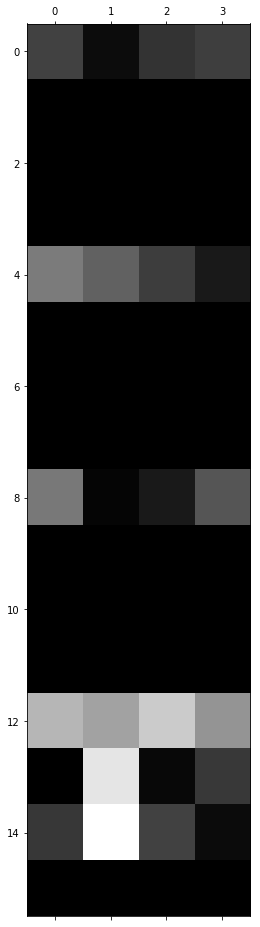

In [50]:
plt.matshow(inputs2.reshape((16,4)), cmap='Greys_r')

In [51]:
D(Variable(torch.from_numpy(inputs2.flatten()).float(), requires_grad=True))

Variable containing:
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
 0.5614
[torch.FloatTensor of size 64x1]